# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Данные

[final_steel.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f3fbea3a-263d-4e1c-babd-0bf07920c911/final_steel.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_steel/`.

### Цель проекта
Построить модель машинного обучения для предсказания температуры стали.

Достигнуть MAE от 8.7 до 6 и ниже

### план работы :
1. Предобработка данных
Перевод даты в datetime формат, обработка выбросов (Реактивная мощность, сыпучие вещества, инертный газ), заполнение пропусков при необходимости).

2. Подбор необходимых фич
Нужны ли нам все столбцы Bulk и Wire, В бОльшую часть сплавов добавляют лишь некоторые.

3. Объединение данных в одну таблицу
Выделение целевого и учебных признаков. Скалирование данных при необходимости.

4. Подбор и обучение моделей
Тестирование дамми болванки, деление сета на 3 выборки, подбор гиперпараметров и валидация моделей.

5. Выбор и тестирование финальной модели
Проверка модели на тестовой выборке. Описание результатов.

### Вопросы

Все вопросы в принципе обсудили на консультации, повторю некоторые:

* Датафреймы с временем нам не понадобятся?
* Нужны ли нам все столбцы Bulk и Wire, В бОльшую часть сплавов добавляют лишь некоторые
* выброс минусовой в данных об электродах явная ошибка измерений и его мы спокойно удаляем?
* МАЕ используем для модели и нужно получить меньше 8.7?
* data_bulk NAN тут это значит ничего не добавлялось и эти значения не трогаем?

### Анализ данных

импорт библиотек

In [ ]:
#Импорты должны быть сгруппированы в следующем порядке по PEP-8:
#импорты из стандартной библиотеки
#импорты сторонних библиотек
#импорты модулей текущего проекта

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore')

загружаем датасеты

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [ ]:
def df_info(df):
    
    display(df.head(5))
    display(df.info())
    display(df.describe())
    display(df[df.duplicated(keep="first")].count())

функция для анализа датафрейма

#### Данные об электродах

In [ ]:
df_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [ ]:
data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


14876 строк, 5 столбцов. Описание работы электродов. Данные с 5 мая по 1 сентября 2019 года.

3241 партий металла.

Один цикл работы электродов длится 2-5 минут. На обработку партии металла, уходит от 10 до 30 минут.

Пропуски и дубликаты отсутсвуют.

Посмотрим "ящики с усами" для мощностей.

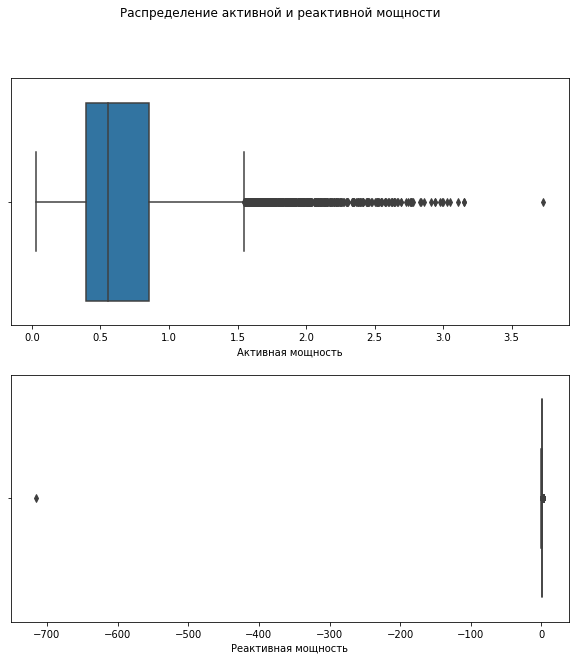

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.boxplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Реактивная мощность'], ax=axes[1])

plt.suptitle('Распределение активной и реактивной мощности');

В каждом столбце есть по одному явному выбросу. Нужно понять выбросы ли это.

In [ ]:
data_arc['Активная мощность'].sort_values(ascending=False)

7799     3.731596
9226     3.156276
12424    3.150762
9870     3.107820
14200    3.052813
           ...   
4914     0.031630
2419     0.030563
5320     0.030190
5596     0.030188
7372     0.030002
Name: Активная мощность, Length: 14876, dtype: float64

In [ ]:
data_arc['Реактивная мощность'].sort_values()

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: Реактивная мощность, Length: 14876, dtype: float64

Нас интересуют строки 7799 и 9780

In [ ]:
data_arc.loc[7799]

key                                    1689
Начало нагрева дугой    2019-07-02 18:49:03
Конец нагрева дугой     2019-07-02 19:04:10
Активная мощность                  3.731596
Реактивная мощность                2.676388
Name: 7799, dtype: object

Присутствует большое значение реактивной мощности, нагрев продолжался 15 минут.

In [ ]:
data_arc.loc[9780]

key                                    2116
Начало нагрева дугой    2019-07-24 00:44:48
Конец нагрева дугой     2019-07-24 00:46:37
Активная мощность                  0.495782
Реактивная мощность             -715.504924
Name: 9780, dtype: object

Значение похоже на сбой системы.

Рассчитаем полную мощность.

In [ ]:
data_arc_test = data_arc.copy()
data_arc_test['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

In [ ]:
data_arc_test = data_arc_test.drop(9780)

Удалили значение

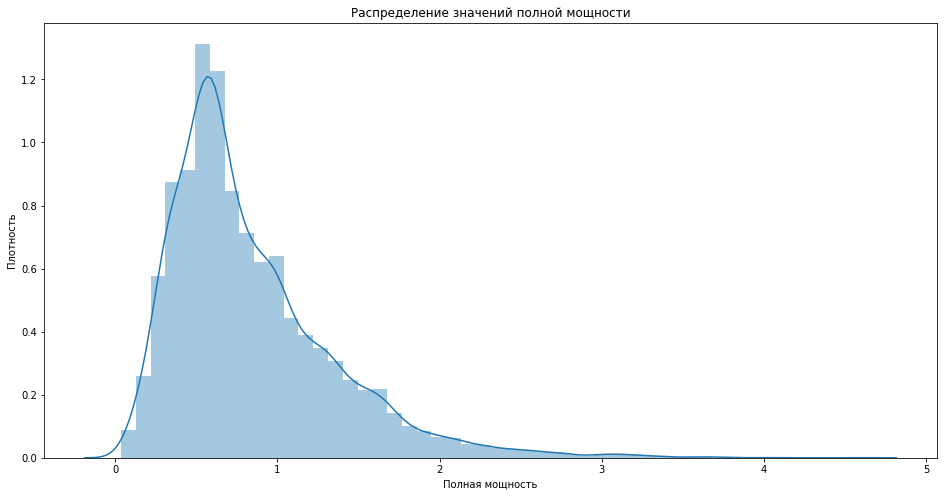

In [ ]:
plt.figure(figsize=(16, 8))

sns.distplot(data_arc_test['Полная мощность'])
plt.ylabel('Плотность')
plt.xlabel('Полная мощность')
plt.title('Распределение значений полной мощности');

Виден длинный правый хвост. Больщая часть значений находится в диапазоне 0,6.

In [ ]:
data_arc_test.loc[data_arc_test['Полная мощность'] >= 3]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
94,21,2019-05-04 03:34:47,2019-05-04 03:44:45,2.629083,1.691524,3.126233
198,44,2019-05-05 00:36:13,2019-05-05 00:46:45,2.343373,1.921817,3.030639
239,51,2019-05-05 05:49:45,2019-05-05 05:59:56,2.772319,1.872731,3.345575
405,88,2019-05-06 11:28:20,2019-05-06 11:37:21,2.551536,1.861429,3.158363
541,118,2019-05-07 18:37:31,2019-05-07 18:48:08,2.375788,1.917851,3.053280
...,...,...,...,...,...,...
13664,2964,2019-08-23 01:02:24,2019-08-23 01:12:20,2.834900,1.833726,3.376271
13760,2985,2019-08-23 19:03:07,2019-08-23 19:14:14,2.779279,2.335088,3.630018
14181,3082,2019-08-27 01:22:31,2019-08-27 01:32:02,2.500275,1.683092,3.013997
14200,3086,2019-08-27 03:41:09,2019-08-27 03:53:10,3.052813,2.216230,3.772445


Проверим, какие записи об обработке отсутсвуют.

In [ ]:
keys_values = data_arc_test['key'].unique()
print(len(data_arc_test['key'].unique()))

3214


3214 операции. А у нас по ключам 3241 операция. Найдем пропущенные значения.

In [ ]:
missing_keys = []

for i in range(len(keys_values)-1):
    
    if keys_values[i] == keys_values[i+1] - 1:
        continue
    else:
        key = keys_values[i]+1
        missing_keys.append(key)
        
missing_keys, len(missing_keys)

([41,
  195,
  279,
  355,
  382,
  506,
  529,
  540,
  607,
  683,
  710,
  766,
  1133,
  1300,
  1437,
  2031,
  2103,
  2278,
  2356,
  2373,
  2446,
  2469,
  2491,
  2683,
  3200,
  3207],
 26)

In [ ]:
for i in missing_keys:
    display(data_arc_test.loc[data_arc_test['key'] == i+1])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
913,196,2019-05-10 15:05:11,2019-05-10 15:07:42,0.531242,0.388698,0.658258
914,196,2019-05-10 15:38:47,2019-05-10 15:40:10,0.354862,0.231908,0.423921
915,196,2019-05-10 15:40:46,2019-05-10 15:42:05,0.354461,0.240250,0.428209


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
1273,280,2019-05-13 23:16:51,2019-05-13 23:19:30,0.531808,0.432575,0.685523
1274,280,2019-05-13 23:24:09,2019-05-13 23:26:34,0.629088,0.397341,0.744064
1275,280,2019-05-13 23:28:08,2019-05-13 23:33:10,1.380310,0.767380,1.579280
1276,280,2019-05-13 23:34:16,2019-05-13 23:39:29,1.468543,0.809540,1.676894
1277,280,2019-05-13 23:41:57,2019-05-13 23:44:16,0.618050,0.365958,0.718269
1278,280,2019-05-13 23:45:50,2019-05-13 23:50:26,1.174957,0.716081,1.375971
1279,280,2019-05-13 23:53:05,2019-05-13 23:55:05,0.507910,0.307163,0.593567
1280,280,2019-05-13 23:56:57,2019-05-14 00:01:43,1.197192,0.728587,1.401466
1281,280,2019-05-14 00:05:53,2019-05-14 00:07:00,0.282393,0.170042,0.329636


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
1652,356,2019-05-16 18:59:38,2019-05-16 19:01:42,0.451559,0.374456,0.586620
1653,356,2019-05-16 19:08:26,2019-05-16 19:13:36,1.285364,0.979460,1.616014
1654,356,2019-05-16 19:19:36,2019-05-16 19:24:38,1.309269,0.941132,1.612425
1655,356,2019-05-16 19:32:43,2019-05-16 19:36:34,1.015459,0.698430,1.232461


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
1768,383,2019-05-17 18:48:00,2019-05-17 18:50:25,0.557739,0.406088,0.689913
1769,383,2019-05-17 18:54:32,2019-05-17 18:56:25,0.434578,0.350117,0.558068
1770,383,2019-05-17 19:01:18,2019-05-17 19:02:26,0.266819,0.202137,0.334741
1771,383,2019-05-17 19:24:13,2019-05-17 19:26:31,0.623035,0.408613,0.745075


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
2355,507,2019-05-22 07:08:12,2019-05-22 07:10:29,0.532599,0.389240,0.659674
2356,507,2019-05-22 07:14:51,2019-05-22 07:17:50,0.697734,0.567233,0.899214
2357,507,2019-05-22 07:19:14,2019-05-22 07:24:27,1.390591,0.965243,1.692760
2358,507,2019-05-22 07:27:11,2019-05-22 07:33:34,1.745092,1.144200,2.086753
2359,507,2019-05-22 08:17:20,2019-05-22 08:21:16,1.064305,0.701169,1.274513
2360,507,2019-05-22 08:23:17,2019-05-22 08:27:19,1.060903,0.698771,1.270352
2361,507,2019-05-22 08:34:57,2019-05-22 08:36:39,0.453759,0.299649,0.543771


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
2456,530,2019-05-22 22:48:30,2019-05-22 22:52:31,0.866785,0.697797,1.112761


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
2494,541,2019-05-23 08:14:26,2019-05-23 08:17:43,0.696466,0.506860,0.861378
2495,541,2019-05-23 08:20:55,2019-05-23 08:25:27,0.895490,0.737648,1.160184
2496,541,2019-05-23 08:28:42,2019-05-23 08:31:49,0.705720,0.499061,0.864351
2497,541,2019-05-23 08:42:07,2019-05-23 08:44:58,0.720513,0.479535,0.865502
2498,541,2019-05-23 08:59:29,2019-05-23 09:01:07,0.440914,0.293281,0.529546


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
2795,608,2019-05-25 18:34:59,2019-05-25 18:37:00,0.373422,0.282934,0.468504
2796,608,2019-05-25 18:39:32,2019-05-25 18:44:45,1.030622,0.843950,1.332078
2797,608,2019-05-25 18:47:24,2019-05-25 18:48:28,0.227790,0.166905,0.282393
2798,608,2019-05-25 18:52:25,2019-05-25 18:56:37,0.852898,0.796612,1.167058


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
3151,684,2019-05-28 15:27:56,2019-05-28 15:32:06,0.973453,0.825564,1.276388
3152,684,2019-05-28 15:33:17,2019-05-28 15:35:05,0.429088,0.372028,0.567909
3153,684,2019-05-28 15:36:10,2019-05-28 15:39:08,0.802865,0.570025,0.984643
3154,684,2019-05-28 15:41:03,2019-05-28 15:46:21,1.517004,0.925427,1.776996
3155,684,2019-05-28 15:47:47,2019-05-28 15:53:10,1.515680,0.944811,1.786044
3156,684,2019-05-28 15:55:45,2019-05-28 15:57:52,0.597258,0.369133,0.702123


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
3288,711,2019-05-29 18:06:07,2019-05-29 18:08:26,0.449686,0.356106,0.573610
3289,711,2019-05-29 18:09:36,2019-05-29 18:12:18,0.645819,0.479464,0.804343
3290,711,2019-05-29 18:13:47,2019-05-29 18:17:51,1.029058,0.753656,1.275523
3291,711,2019-05-29 18:19:56,2019-05-29 18:24:43,1.222942,0.867077,1.499137


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
3536,767,2019-05-31 23:26:32,2019-05-31 23:29:03,0.503979,0.378955,0.630556
3537,767,2019-05-31 23:32:46,2019-05-31 23:35:31,0.550453,0.465964,0.721194
3538,767,2019-05-31 23:50:13,2019-05-31 23:52:11,0.507567,0.336815,0.609154


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
5224,1134,2019-06-13 13:22:58,2019-06-13 13:25:06,0.503174,0.374759,0.627398
5225,1134,2019-06-13 13:30:49,2019-06-13 13:32:34,0.403382,0.311169,0.509454
5226,1134,2019-06-13 13:38:27,2019-06-13 13:40:39,0.560723,0.396547,0.686775
5227,1134,2019-06-13 13:46:09,2019-06-13 13:50:16,1.075202,0.756505,1.314670
5228,1134,2019-06-13 13:59:41,2019-06-13 14:02:20,0.692613,0.477658,0.841350
5229,1134,2019-06-13 14:06:03,2019-06-13 14:06:54,0.213226,0.147038,0.259009


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
5969,1301,2019-06-19 06:51:46,2019-06-19 06:53:29,0.360470,0.266430,0.448245
5970,1301,2019-06-19 06:55:28,2019-06-19 06:59:39,1.072808,0.815253,1.347425
5971,1301,2019-06-19 07:23:56,2019-06-19 07:24:58,0.271999,0.194674,0.334487
5972,1301,2019-06-19 07:26:10,2019-06-19 07:28:50,0.714998,0.489924,0.866745
5973,1301,2019-06-19 07:30:40,2019-06-19 07:34:36,1.043104,0.712758,1.263364


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
6607,1438,2019-06-24 02:27:44,2019-06-24 02:29:50,0.363184,0.583708,0.687472
6608,1438,2019-06-24 02:40:15,2019-06-24 02:43:23,0.779512,0.774157,1.098616
6609,1438,2019-06-24 02:58:15,2019-06-24 03:00:02,0.407010,0.473591,0.624456
6610,1438,2019-06-24 03:03:26,2019-06-24 03:09:42,1.657588,1.347631,2.136284
6611,1438,2019-06-24 03:13:08,2019-06-24 03:16:20,0.810655,0.683794,1.060535
6612,1438,2019-06-24 03:18:07,2019-06-24 03:19:32,0.364829,0.315143,0.482094


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
9370,2032,2019-07-20 21:51:38,2019-07-20 21:53:50,0.453800,0.328750,0.560366
9371,2032,2019-07-20 22:08:44,2019-07-20 22:11:02,0.537712,0.459403,0.707238
9372,2032,2019-07-20 22:30:50,2019-07-20 22:32:22,0.354215,0.272609,0.446972


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
9702,2104,2019-07-23 08:12:38,2019-07-23 08:15:23,0.578512,0.426996,0.719028
9703,2104,2019-07-23 08:25:15,2019-07-23 08:29:59,1.277633,0.883057,1.553105
9704,2104,2019-07-23 08:45:01,2019-07-23 08:48:02,0.807341,0.576806,0.992223
9705,2104,2019-07-23 08:52:28,2019-07-23 08:52:59,0.121445,0.085203,0.148353
9706,2104,2019-07-23 08:54:59,2019-07-23 09:00:06,1.329247,0.980762,1.651906
9707,2104,2019-07-23 09:11:12,2019-07-23 09:14:10,0.794798,0.576204,0.981690
9708,2104,2019-07-23 09:16:31,2019-07-23 09:16:49,0.064994,0.046329,0.079816
9709,2104,2019-07-23 09:17:27,2019-07-23 09:18:51,0.366758,0.280175,0.461530


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
10481,2279,2019-07-29 04:20:25,2019-07-29 04:22:44,0.483324,0.351886,0.597851
10482,2279,2019-07-29 04:27:15,2019-07-29 04:30:16,0.440148,0.418907,0.607629
10483,2279,2019-07-29 04:49:24,2019-07-29 04:51:11,0.380086,0.249555,0.454690
10484,2279,2019-07-29 04:53:19,2019-07-29 04:55:27,0.441830,0.304518,0.536605
10485,2279,2019-07-29 04:57:01,2019-07-29 04:58:14,0.256547,0.165236,0.305154
10486,2279,2019-07-29 04:59:06,2019-07-29 05:00:33,0.306803,0.193483,0.362717


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
10831,2357,2019-07-31 20:48:09,2019-07-31 20:50:06,0.415543,0.291163,0.507398
10832,2357,2019-07-31 20:54:27,2019-07-31 20:57:32,0.635020,0.529055,0.826529
10833,2357,2019-07-31 21:11:19,2019-07-31 21:14:22,0.793427,0.606518,0.998694


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
10902,2374,2019-08-01 19:44:14,2019-08-01 19:46:28,0.460998,0.354677,0.581648
10903,2374,2019-08-01 19:49:49,2019-08-01 19:52:45,0.750640,0.595272,0.958023
10904,2374,2019-08-01 19:57:00,2019-08-01 20:00:20,0.907836,0.639066,1.110212
10905,2374,2019-08-01 20:03:54,2019-08-01 20:06:33,0.632872,0.465624,0.785705


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
11233,2447,2019-08-04 04:53:46,2019-08-04 04:55:47,0.407968,0.298258,0.505367
11234,2447,2019-08-04 05:02:55,2019-08-04 05:06:03,0.650231,0.579873,0.871237
11235,2447,2019-08-04 05:29:04,2019-08-04 05:31:20,0.604442,0.404065,0.727062


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
11329,2470,2019-08-05 00:57:53,2019-08-05 01:00:52,0.613309,0.475254,0.775895
11330,2470,2019-08-05 01:07:49,2019-08-05 01:11:34,0.749570,0.631038,0.979829
11331,2470,2019-08-05 01:29:38,2019-08-05 01:30:52,0.244753,0.182578,0.305350


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
11418,2492,2019-08-05 22:37:53,2019-08-05 22:40:01,0.451012,0.340561,0.565149
11419,2492,2019-08-05 22:49:38,2019-08-05 22:55:57,1.336915,1.078713,1.717837
11420,2492,2019-08-05 23:05:44,2019-08-05 23:08:39,0.783357,0.514980,0.937471


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
12350,2684,2019-08-12 14:49:17,2019-08-12 14:51:28,0.453418,0.330635,0.561166
12351,2684,2019-08-12 15:04:58,2019-08-12 15:06:46,0.373135,0.280805,0.466992
12352,2684,2019-08-12 15:19:07,2019-08-12 15:21:46,0.626338,0.484421,0.791810
12353,2684,2019-08-12 15:30:03,2019-08-12 15:32:52,0.730190,0.494385,0.881813
12354,2684,2019-08-12 15:33:47,2019-08-12 15:35:30,0.440583,0.286786,0.525699


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
14704,3201,2019-08-30 21:42:25,2019-08-30 21:44:29,0.415246,0.327720,0.528989
14705,3201,2019-08-30 21:49:03,2019-08-30 21:52:03,0.646498,0.489845,0.811115
14706,3201,2019-08-30 21:53:50,2019-08-30 21:54:51,0.211817,0.164495,0.268188
14707,3201,2019-08-30 22:08:29,2019-08-30 22:11:02,0.673396,0.473263,0.823068
14708,3201,2019-08-30 22:13:32,2019-08-30 22:15:53,0.645816,0.437943,0.780303


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
14732,3208,2019-08-31 01:47:35,2019-08-31 01:49:49,0.448066,0.311453,0.545680
14733,3208,2019-08-31 01:50:42,2019-08-31 01:56:59,1.520766,1.133155,1.896515
14734,3208,2019-08-31 01:58:39,2019-08-31 02:01:23,0.749844,0.514677,0.909483
14735,3208,2019-08-31 02:02:24,2019-08-31 02:08:38,1.700265,1.179449,2.069300


In [ ]:
missing_keys.append(42)
len(missing_keys)

27

Отсутсвует запись со значением key = 42. Это никак не влияет на построение финальной модели.

#### Сыпучие материалы

In [ ]:
df_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [ ]:
data_bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Перед нами данные о добавлении сыпучих масс в процессе легирования стали.

Посмотрим на выбросы.

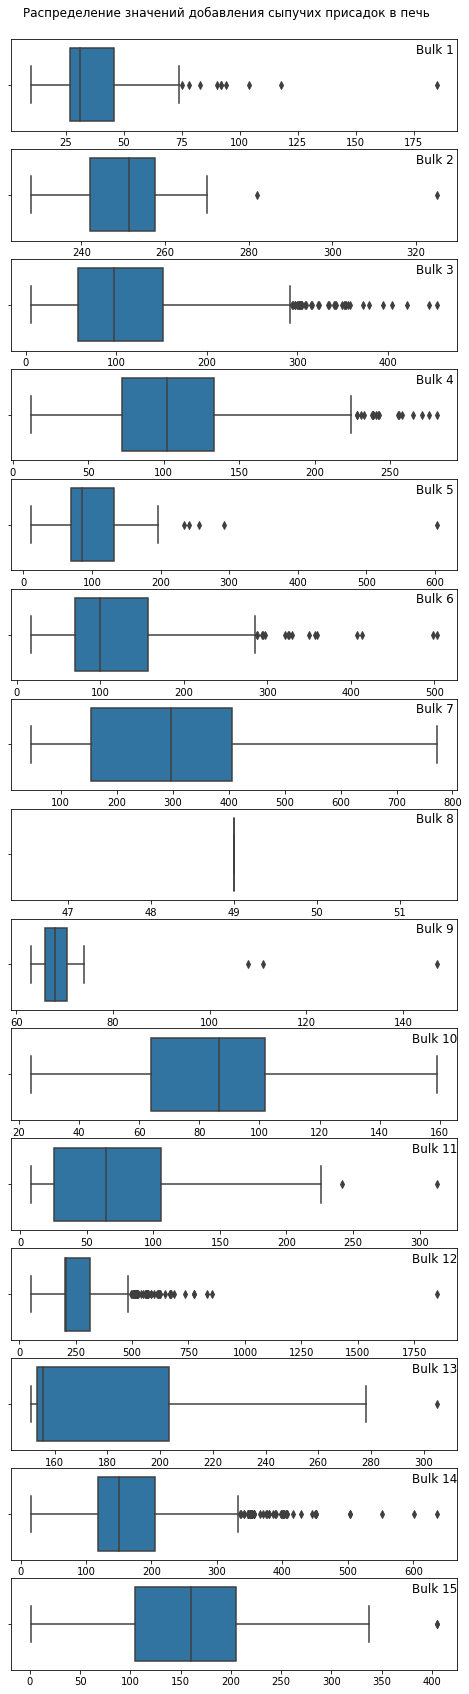

In [ ]:
fig, axes = plt.subplots(15,1, figsize=(8,30))

for i, j in zip(data_bulk.columns[1:], range(data_bulk.shape[1]+1)):
                    sns.boxplot(data_bulk[i], ax=axes[j])
                    axes[j].set_title(i, x=0.95, y=0.78, size=12)

axes[14].set_xlabel('')

plt.suptitle('Распределение значений добавления сыпучих присадок в печь', y=0.895);

Пропуски в данных, означают то, что тот или иной сыпучий материал Bulk # не использовался в процессе производства той или иной партии.

#### Время подачи сыпучих материалов

In [ ]:
df_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Датафрем не поможет нам с рассчетами и его можно не обрабатывать.

#### Продувка сплава газом

In [ ]:
df_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


key      0
Газ 1    0
dtype: int64

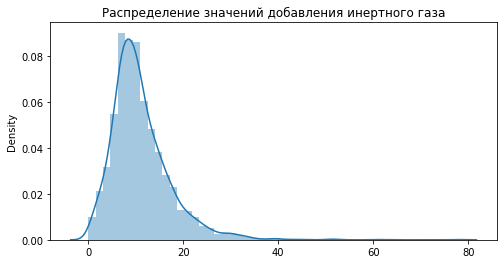

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(data_gas['Газ 1'])
plt.xlabel('')
plt.title('Распределение значений добавления инертного газа');

Выбросов в данных нет.

#### Температура

In [ ]:
df_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


key             0
Время замера    0
Температура     0
dtype: int64

15907 записей. Пропусков и дубликатов не обнаружено.

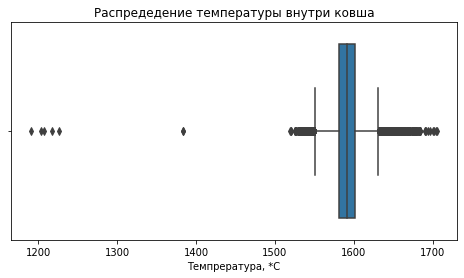

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data_temp['Температура'])
plt.xlabel('Темпрература, *С')
plt.title('Распредедение температуры внутри ковша');

Заметно большое количество значений существенно ниже средней температуры в рабочей камере. Посмотрим, сколько всего таких значений.

In [ ]:
data_temp.loc[data_temp['Температура'] <= 1500].shape

(7, 3)

В 7 случаях температура была ниже 1500

In [ ]:
data_temp.tail(5)

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


На последних этапах отсутсвуют измерения финальной температуры

Есть немного выбросов в начальной и конечной температурах, которые можно исключить из итоговой таблицы

#### Проволочные материалы

In [ ]:
df_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

В расплавленный металл могут подавать 9 различных проволочных материалов. В основном в ход идут образцы 1 и 2. В каждую партию металла добавляли хотя бы одну проволоку.

#### Время подачи проволоки

In [ ]:
df_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Датафрейм не участвует в расчетах.

### Предобработка данных

удаляем выброс

In [ ]:
data_arc = data_arc.drop(9780)

Составим из таблицы data_arc сгрупированную таблицу data_arc_sum по key для объединения данных.

In [ ]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


Удалим из таблицы партии, у которых нет финального замера, когда температуру замеряли до окончания последней операции нагрева дугой и только один замер температуры.

In [ ]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216] 171


Удалим все строки с пропусками.

In [ ]:
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12381 non-null  int64  
 1   Время замера  12381 non-null  object 
 2   Температура   12381 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.9+ KB


In [ ]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1214    16
1513    16
46      16
44      16
2108    15
        ..
1801     2
35       2
1894     2
2194     2
800      2
Name: key, Length: 2344, dtype: int64

In [ ]:
data_temp.columns = ['key', 'time','temp']
pt_data_temp = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


Получен срез со значениями времени начального и конечного замера. Сформируем новый срез на основе времени в data_temp_final.

In [ ]:
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Для объединения нам потребуются таблицы: data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице преобразуем index в значение столбца key.

In [ ]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

Мы предсказываем значение end_temp. Удалим партии, где нет информации о температуре. Столбец wire_5 удалим из-за отсуствия информации во всех запясях.

In [ ]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna(subset=['end_temp'])
data_steel.info()
data_steel = data_steel.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2344 non-null   float64
 1   sum_reactive_power  2344 non-null   float64
 2   start_temp          2344 non-null   float64
 3   end_temp            2344 non-null   float64
 4   bulk_1              189 non-null    float64
 5   bulk_2              13 non-null     float64
 6   bulk_3              931 non-null    float64
 7   bulk_4              758 non-null    float64
 8   bulk_5              53 non-null     float64
 9   bulk_6              433 non-null    float64
 10  bulk_7              13 non-null     float64
 11  bulk_8              1 non-null      float64
 12  bulk_9              13 non-null     float64
 13  bulk_10             130 non-null    float64
 14  bulk_11             124 non-null    float64
 15  bulk_12             1797 non-null   float64
 16  bulk_1

Приведем типы столбцов start_temp, end_temp и bulk составляющих к целому типу, так как там храняться только целые числа. Заранее во все NaN разместим значения 0.

In [ ]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2344 non-null   float64
 1   sum_reactive_power  2344 non-null   float64
 2   start_temp          2344 non-null   int16  
 3   end_temp            2344 non-null   int16  
 4   bulk_1              2344 non-null   int16  
 5   bulk_2              2344 non-null   int16  
 6   bulk_3              2344 non-null   int16  
 7   bulk_4              2344 non-null   int16  
 8   bulk_5              2344 non-null   int16  
 9   bulk_6              2344 non-null   int16  
 10  bulk_7              2344 non-null   int16  
 11  bulk_8              2344 non-null   int8   
 12  bulk_9              2344 non-null   int16  
 13  bulk_10             2344 non-null   int16  
 14  bulk_11             2344 non-null   int16  
 15  bulk_12             2344 non-null   int16  
 16  bulk_1

Выясним зависимости между целевым признаком и остальными признаками.

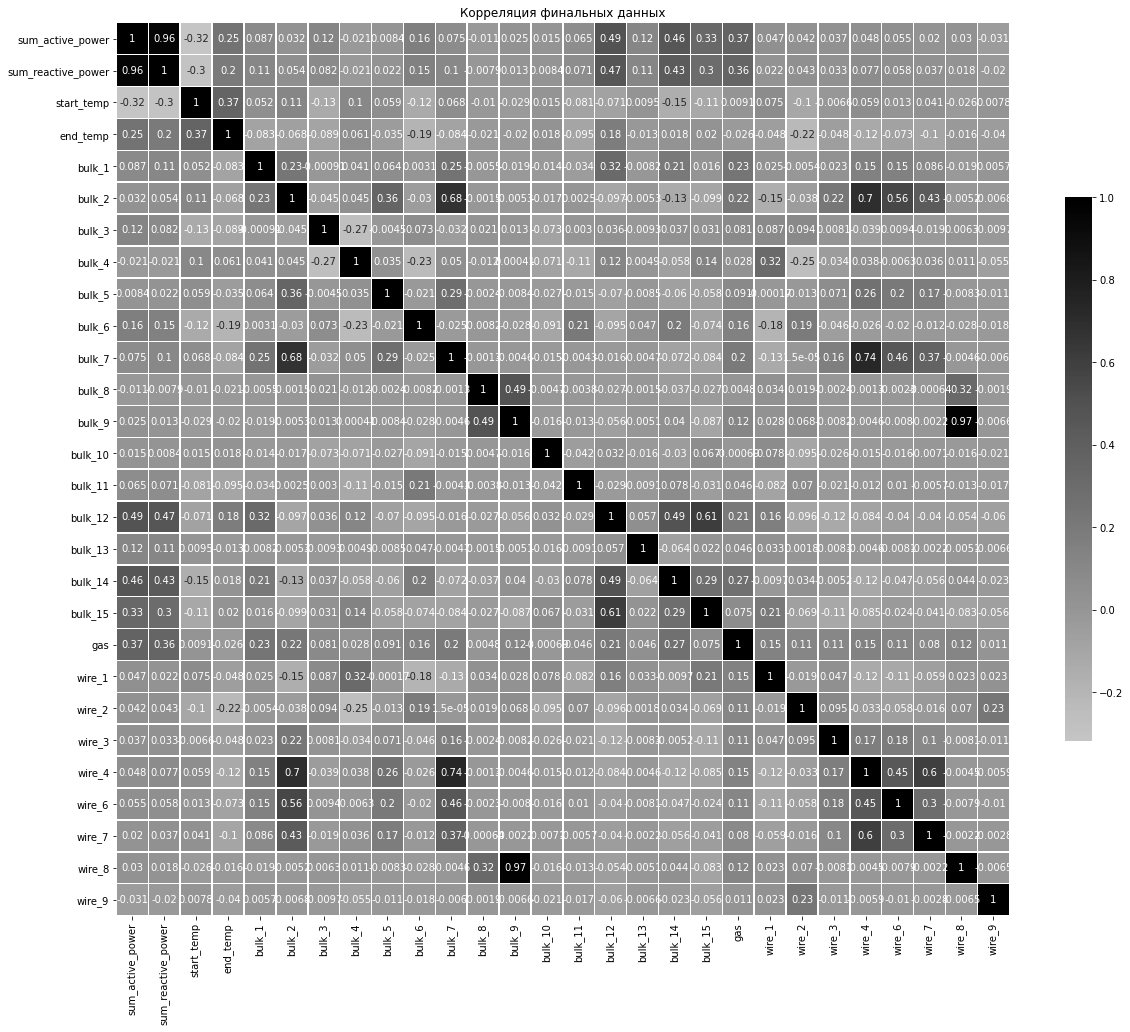

In [ ]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

plt.figure(figsize=(20,20))

sns.heatmap(corr_heatmap_data, center=0, annot=True, cmap='Greys',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Корреляция финальных данных');

Из heatmap видно что есть сильные зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Так как они дублируют по сути друг друга, удалим из обучения sum_reactive_power и wire_8.

In [ ]:
data_steel_knn = data_steel_knn.drop(['sum_reactive_power', 'wire_8'], axis=1)

Оценим, какие столбцы влияют на результат end_temp.

In [ ]:
data_steel_knn.corr()['end_temp'] 

sum_active_power    0.247650
start_temp          0.366398
end_temp            1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas                -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: end_temp, dtype: float64

Не все столбцы значимо влияют на данные. Для выявления аномалий возьмем те, чья корреляция больше 10%

In [ ]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['sum_active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4',
                                          'wire_7']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_knn = data_steel_knn.drop(outlier_indexes)
data_steel_knn.shape

Количество аномалий (KNN):  196


(2148, 26)

#### Вывод
Данные были подготовлены для обучения модели. Целевым признаком является столбец end_temp.

### Обучение модели

Разобьем данные на train и test к соотношению 75/25.

In [ ]:
random_state = 15072022

features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

#### LinearRegression

In [ ]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 7.4412231399391775
CPU times: user 44.4 ms, sys: 167 ms, total: 212 ms
Wall time: 154 ms


#### RandomForestRegressor

In [ ]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
               'n_estimators':[x for x in range(100, 1001, 100)], 
               'random_state':[random_state]}]
# hyperparams = [{'criterion':['mse'],
#                'n_estimators':[1000], 
#               'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 1000, 'random_state': 15072022}

Grid scores on development set:

6.011340 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 15072022}
6.004806 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 15072022}
5.988845 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 15072022}
5.983736 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 15072022}
5.986693 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 15072022}
5.991616 for {'criterion': 'mse', 'n_estimators': 600, 'random_state': 15072022}
5.983198 for {'criterion': 'mse', 'n_estimators': 700, 'random_state': 15072022}
5.983038 for {'criterion': 'mse', 'n_estimators': 800, 'random_state': 15072022}
5.978493 for {'criterion': 'mse', 'n_estimators': 900, 'random_state': 15072022}
5.978129 for {'criterion': 'mse', 'n_estimators': 1000, 'random_state'

#### CatBoostRegressor

In [ ]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 5.86694303361107
CPU times: user 12.8 s, sys: 619 ms, total: 13.4 s
Wall time: 18.1 s


In [ ]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 15072022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04414699971675873,
 'score_function': 'Cosine',
 'tas

In [ ]:
ctb_pool = Pool(features_train, label=target_train)

In [ ]:
scores = cv(ctb_pool,
            best_params_CBR,
            fold_count=2,
            seed=random_state,
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]
0:	learn: 13.3698425	test: 16.0139274	best: 16.0139274 (0)	total: 2.37ms	remaining: 2.37s
1:	learn: 13.1090147	test: 15.6876474	best: 15.6876474 (1)	total: 4.65ms	remaining: 2.32s
2:	learn: 12.8741220	test: 15.4128990	best: 15.4128990 (2)	total: 6.9ms	remaining: 2.29s
3:	learn: 12.6638739	test: 15.2201911	best: 15.2201911 (3)	total: 9.11ms	remaining: 2.27s
4:	learn: 12.4423741	test: 15.0307482	best: 15.0307482 (4)	total: 11.3ms	remaining: 2.24s
5:	learn: 12.2221014	test: 14.8012122	best: 14.8012122 (5)	total: 13.9ms	remaining: 2.3s
6:	learn: 12.0264636	test: 14.5316006	best: 14.5316006 (6)	total: 16.9ms	remaining: 2.4s
7:	learn: 11.8418476	test: 14.2924232	best: 14.2924232 (7)	total: 19.1ms	remaining: 2.37s
8:	learn: 11.6583016	test: 14.0933436	best: 14.0933436 (8)	total: 21.4ms	remaining: 2.36s
9:	learn: 11.4973418	test: 13.8415009	best: 13.8415009 (9)	total: 23.7ms	remaining: 2.35s
10:	learn: 11.3286294	test: 13.6154608	best: 13.6154608 (10)	total: 25.7ms	remai

#### LGBMRegressor

In [ ]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10, 16)], 
               'learning_rate':[x for x in range(1, 6)],
               'random_state':[random_state]}]
# hyperparams = [{'num_leaves':[10], 
#                'learning_rate':[1],
#                'random_state':[random_state]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 1, 'num_leaves': 10, 'random_state': 15072022}

Grid scores on development set:

7.924910 for {'learning_rate': 1, 'num_leaves': 10, 'random_state': 15072022}
7.943482 for {'learning_rate': 1, 'num_leaves': 11, 'random_state': 15072022}
8.361895 for {'learning_rate': 1, 'num_leaves': 12, 'random_state': 15072022}
8.299246 for {'learning_rate': 1, 'num_leaves': 13, 'random_state': 15072022}
8.396248 for {'learning_rate': 1, 'num_leaves': 14, 'random_state': 15072022}
8.182089 for {'learning_rate': 1, 'num_leaves': 15, 'random_state': 15072022}
10.226344 for {'learning_rate': 2, 'num_leaves': 10, 'random_state': 15072022}
10.166708 for {'learning_rate': 2, 'num_leaves': 11, 'random_state': 15072022}
10.427149 for {'learning_rate': 2, 'num_leaves': 12, 'random_state': 15072022}
10.230700 for {'learning_rate': 2, 'num_leaves': 13, 'random_state': 15072022}
10.471689 for {'lea

#### XGBRegressor

In [ ]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x for x in range(1, 6)],
                'random_state':[random_state]}]
# hyperparams = [{'learning_rate':[1],
#               'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 1, 'random_state': 15072022}

Grid scores on development set:

7.661138 for {'learning_rate': 1, 'random_state': 15072022}
1366.046997 for {'learning_rate': 2, 'random_state': 15072022}
1800212869356314727775909533712384.000000 for {'learning_rate': 3, 'random_state': 15072022}
nan for {'learning_rate': 4, 'random_state': 15072022}
nan for {'learning_rate': 5, 'random_state': 15072022}

CPU times: user 1min 12s, sys: 251 ms, total: 1min 13s
Wall time: 1min 13s


In [ ]:
index = ['Linear',
         'RandomForest',
         'CatBoost',
         'LGBM',
         'XGB']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)

scores_data

,MAE на CV
Linear,7.441223
RandomForest,5.978129
CatBoost,5.866943
LGBM,7.924910
XGB,7.661138


#### Вывод
Были выбраны и обучены модели для предсказания финальной температуры. Произведен поиск гиперпараметров для получения лучшего результата. CatBoost на CV показывает лучший результат MAE 5.866943

### Тестирование моделей

Протестируем все модели для оценки их эффективности. Необходимо достичь метрику МАЕ до 8.7 или ниже 6.

In [ ]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.594564278427236
CPU times: user 3.28 s, sys: 63.4 ms, total: 3.35 s
Wall time: 4.75 s


### Итоговый вывод

Для бизнеса рекомендуется использовать данную модель для предсказания температуры это поможет снизить затраты.

Порог MAE ниже 6 выполнен CatBoost

Лучшей моделью по метрике MAE = 5.59 стал CatBoost. Этот результат показывает, что модель в среднем ошибается на 5-6 градусов температуры.

* Подготовлены данные. Изменены типы данных; определены и использованы номера партий, у которых есть замеры по температуре.
* Подготовлены признаки. Составлена единая таблица со всеми данными для модели. Выделен целевой признак как последний замер в серии замеров. Разделены на features и target со смешиванием данных.
* Выбраны модели. Использованы и обучены регрессионные модели.
* Оценена эффективность моделей на тестовой выборке.

### Финальный отчет

* Какие пункты плана были выполнены, а какие — нет (поясните почему)?
* Какие трудности возникли и как вы их преодолели?
* Какие ключевые шаги в решении задачи выделили?
* Какая ваша итоговая модель и какое у неё качество?

#### план работы

Предобработка данных Перевод даты в datetime формат, обработка выбросов (Реактивная мощность, сыпучие вещества, инертный газ), заполнение пропусков при необходимости). — выполнено

Подбор необходимых фич Нужны ли нам все столбцы Bulk и Wire, В бОльшую часть сплавов добавляют лишь некоторые. — выполнено, взяли не все столбцы, wire_5 удалии из-за отсуствия информации во всех запясях.

Объединение данных в одну таблицу Выделение целевого и учебных признаков. Скалирование данных при необходимости. — выполнено.

Подбор и обучение моделей Тестирование дамми болванки, деление сета на 3 выборки, подбор гиперпараметров и валидация моделей. — выполнено частично, без тестировании дамми болванкой, в которой не было необходимости.

Выбор и тестирование финальной модели Проверка модели на тестовой выборке. Описание результатов. — выполнено.

#### Какие трудности возникли и как вы их преодолели?

Трудности были при анализе датафреймов, их преодолели в обсуждении с тимлидом на зум встрече

#### Какие ключевые шаги в решении задачи выделили?

Из ключевых шагов в данной задаче, выделяются анализ датафреймов, предобработка данных

#### Какая ваша итоговая модель и какое у неё качество?

MAE = 5.59 CatBoost